# Preparing the Dataset

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
from geopandas.tools import overlay
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps,annual_revenue,log_price,log_pps,price_bin
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,...,0.03,1,267,1,NaN,5775,26950,5.616771,8.661294,260
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,...,0.73,1,0,0,NaN,150,27375,4.317488,5.010635,60
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.764570,-73.983170,Private room,68,...,3.38,1,79,50,NaN,136,19448,4.219508,4.912655,60
6,5803,"Lovely Room 1 in BEST AREA; Legal Rental, Spot...",9744,Laurie,Brooklyn,South Slope,40.668010,-73.987840,Private room,124,...,1.31,3,163,14,NaN,496,25048,4.820282,6.206576,120
8,7097,Perfect for Your Parents: Privacy + Garden,17571,Jane,Brooklyn,Fort Greene,40.691233,-73.972702,Entire home/apt,220,...,2.01,2,38,36,NaN,660,71940,5.393628,6.492240,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41525,772714221060214808,Good Vibes at The Bronx,421264574,Aridio,Bronx,Unionport,40.828074,-73.847886,Entire home/apt,125,...,NaN,1,60,0,NaN,250,38125,4.828314,5.521461,120
41526,772716724205003579,2 bedroom Condo near West Village,481177884,Steven,Manhattan,Chelsea,40.740030,-73.997302,Entire home/apt,1114,...,NaN,2,355,0,NaN,3342,11140,7.015712,8.114325,1100
41527,771961589340472067,Habitación Privada,409771624,Camila,Queens,Sunnyside,40.742223,-73.923310,Private room,124,...,NaN,1,360,0,NaN,248,620,4.820282,5.513429,120
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.847271,-73.943419,Private room,80,...,NaN,3,358,0,NaN,400,560,4.382027,5.991465,80


,price,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,annual_revenue
0,275,0.03,1,267,1,26950
1,75,0.73,1,0,0,27375
3,68,3.38,1,79,50,19448
6,124,1.31,3,163,14,25048
8,220,2.01,2,38,36,71940
...,...,...,...,...,...,...
41525,125,NaN,1,60,0,38125
41526,1114,NaN,2,355,0,11140
41527,124,NaN,1,360,0,620
41528,80,NaN,3,358,0,560


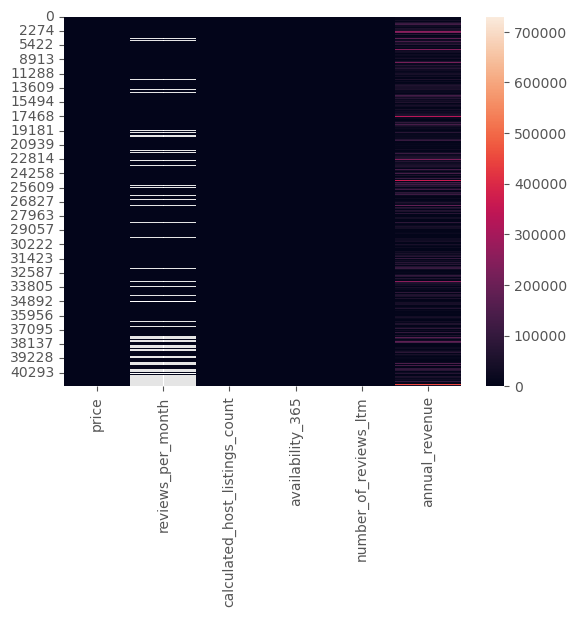

In [4]:
heatmap_df = df[['price','reviews_per_month','calculated_host_listings_count','availability_365','number_of_reviews_ltm','annual_revenue']]
# pivot_table = heatmap_df.pivot(indexb
sns.heatmap(heatmap_df)
heatmap_df

Text(0.5, 1.0, "Pearson's Correlation Heatmap")

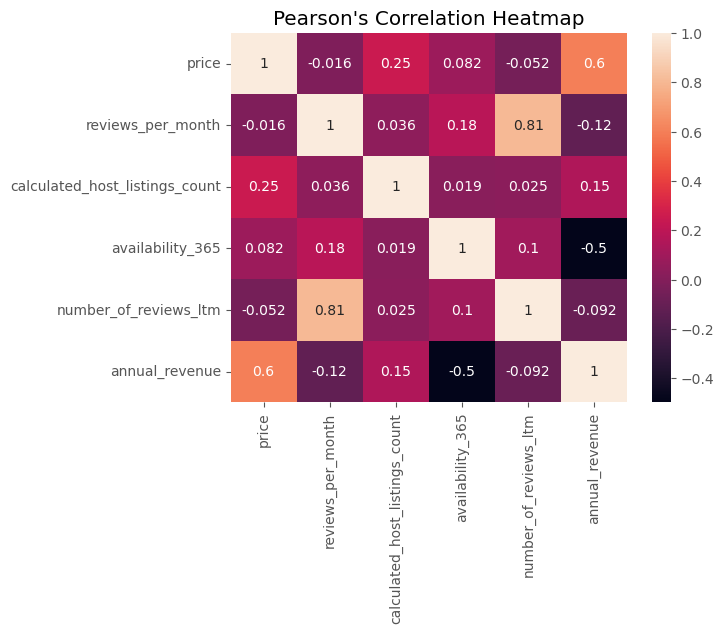

In [14]:
# calculate the correlation matrix
corr = heatmap_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)
plt.title('Pearson\'s Correlation Heatmap')

Pearson's Correlation Heatmap
only used on continuous variables
ANOVA test for room type (compares categorical inputs with continuous output_

https://www.tutorialspoint.com/correlation-between-categorical-and-continuous-variables#:~:text=The%20ANOVA%20and%20Point%20Biserial,primary%20assumption%20of%20both%20methods.

In [3]:
price_bin_grouping_mean = df.groupby('price_bin').mean()
price_bin_grouping_count = df.groupby('price_bin').count()
price_bin_grouping_count = price_bin_grouping_count[['price']]
price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
price_bin_grouping = pd.merge(price_bin_grouping_mean,price_bin_grouping_count, how = 'left', on= 'price_bin')

# all listings

<AxesSubplot:xlabel='price_bin', ylabel='price_bin_count'>

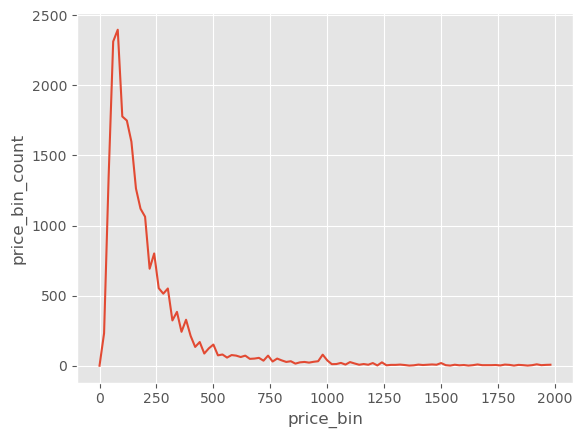

In [4]:
sns.lineplot(x = price_bin_grouping.index, y = 'price_bin_count', data=price_bin_grouping)

<AxesSubplot:xlabel='price_bin', ylabel='availability_365'>

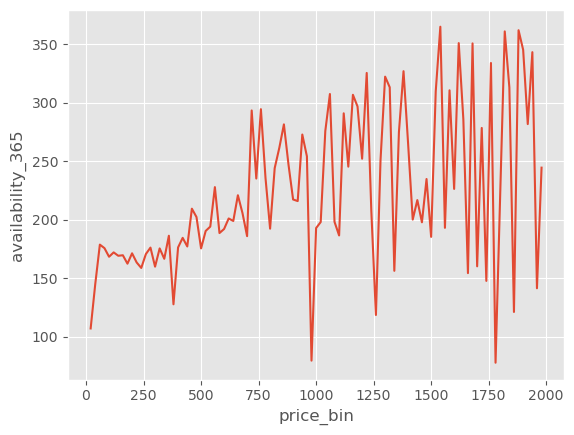

In [5]:
sns.lineplot(x = price_bin_grouping.index, y = 'availability_365', data=price_bin_grouping)

This may show that there may be a market at the 225-250 price bin. This is because there seems to be less availbility in the 250 bin. How much would be needed to justify the increase in price into a new price bin? What can you do as a lister to justify the jump in annual revenue? 

For example what could I do with 2000 that would justify my client paying $20 more per night. 



There is less competition at 250 than at 200 price bin, while also having what seems to be a higher estimated revenue and lower average availablity meaning there is still demand for this price bin. The amount of listing in this criteria may be underserving the demand. 



Text(0, 0.5, 'Average Annual Revenue')

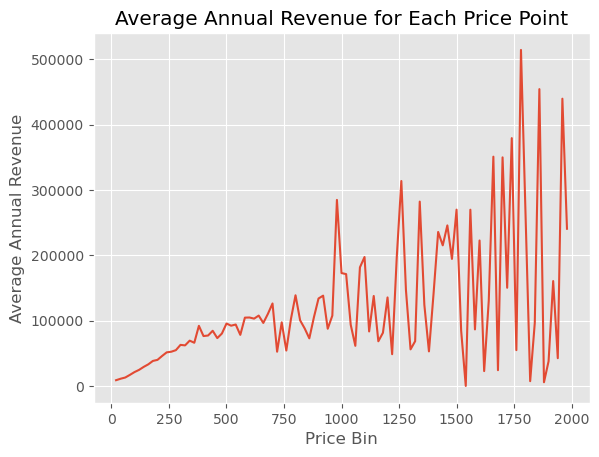

In [6]:
sns.lineplot(x = price_bin_grouping.index, y = 'annual_revenue', data=price_bin_grouping)
plt.title('Average Annual Revenue for Each Price Point')
plt.xlabel('Price Bin')
plt.ylabel('Average Annual Revenue')

Text(0, 0.5, 'Average Reviews Per Month')

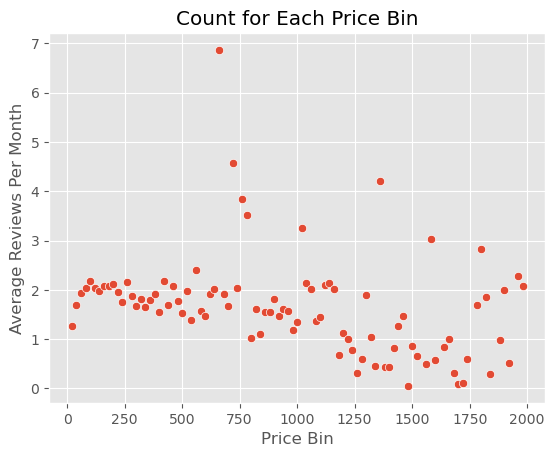

In [7]:
sns.scatterplot(x = price_bin_grouping.index, y = 'reviews_per_month', data=price_bin_grouping)
plt.title('Count for Each Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Average Reviews Per Month')